# Mechanistic Interpretability: What's superposition?

Mechanistic interpretability is an emerging areas of research in AI focused on understanding the inner workings of neural networks. LLMs and Diffusion models have taken the world by storm in the past couple of years and despite they're jaw dropping capabilities very little is known about how and why these deep neural networks generate these outputs.

In this series of articles we'll attempt to breakdown some of the key ideas of Mechanistic Interpretability (mech interp.). We haven't found many good resources to understand the fundamentals of mech interp, there's a sense of irony in how obtuse and dense the literature on a field that aims to make it easier to understand neural nets is :sweat_smile. 

As a novice diving into this area of research my goal is to improve my understanding of the topic as we learn and also hopefully make it easier for others to learn too. The initial articles will be heavily based on a [blog](https://transformer-circuits.pub/2022/toy_model/index.html) released by Anthropic and team in 2022, the [code](https://colab.research.google.com/github/anthropics/toy-models-of-superposition/blob/main/toy_models.ipynb) encompassed in this series largely derives from it too. We found the blog quite dense for a newbie to follow so my aim is to dumb it down as much as possible. Word of caution, that even my series expects readers to have a good understanding of ML and how to train Deep Neural Networks. If you've completed a ML 101 class in your schooling you should have no trouble following these articles.

## Superposition
I came across the idea of superposition in one of 3Blue1Brown's [videos](https://www.youtube.com/watch?v=9-Jl0dxWQs8) on LLMs, and it had be intrigued right away.

Suppose your data is N-dimensional i.e. has N different features and your model projects the N-dimensional data into a smaller H-dimensional vector space. Superposition is the ability of the model to learn to represent **more features than there are dimensions**. So if we denote the number of features a model learns to represent as C i.e. **C>H**.

_Note that in the above scenario, we assume that we've gotten rid of all redundant features in our original dataset._

### Defining a Neuron
A neuron in a neural network corresponds to a group of weights. Throughout this article we define a neuron is a specific row in a weight matrix. If weight matrix W has shape [N, H]. Each row i.e. W[i] of shape (H, ) corresponds to a neuron.

### Defining Features
The notion of a feature can get murky when we speak about unstructured data vs structured data, where the former is much more subjective. In the original blog a feature is defined as "properties of the input which a sufficiently large neural network will reliably dedicate a neuron to representing.". We like to think of a feature as some property of the input that helps a model solve the task at hand.

In an ideal world we'd like to have completely disparate/distinct neurons to represent a feature. i.e. a one to one mapping between features and neurons, there've been multiple works showing how certain neurons are activated by specific features like edge detectors in vision models or entities in text based models. However in practice we see that some features might not be represented at all and/or some neurons might be **polysemantic** i.e. they are sensitive to multiple features which can seemingly be unrelated. Superposition serves as an explanation for how neurons can be polysemantic. 

## How does Superposition work?

Now that we understand what superposition is, we now need to figure out how superposition is likely to manifest and whether this predicted manifestation can be empirically seen.

One of the key assumptions of superposition is that **Features are represented as directions.** This shouldn't come as much of a surprise if you've ever worked with any kind of embedding models before, where different concepts/entities that are related to each other have high cosine similarities. Cosine similarity measure of the degree to which two vectors are pointing in the same direction. That's why a cosine similarity score of 1 corresponds to an angle of 0 degrees (cos(0) = 1).

Okay now that we know that features are represented as directions, the question is how do we figure out what directions to look at in search for these features, after all there an infinite number of directions in any n-d space (n>1). 

Superposition hypothesizes that each neuron represents the direction of a feature. i.e. each row of the W matrix is the direction we should be looking at, in search for a feature. In the original article these directions are called _privileged basis_. A basis can be thought of as a reference framework to locate any point in a given vector space. The x and y axes are examples of a basis in a 2-d space. So you can visualize each of the rows of a weight matrix i.e. each neuron as an axes in the H-D space we project the input features to.

### Superposition, Orthogonality and Interference

The dot product between two vectors represents the projection of one vector onto another. To make sense of that let's visualize "proejcting a vector onto another".

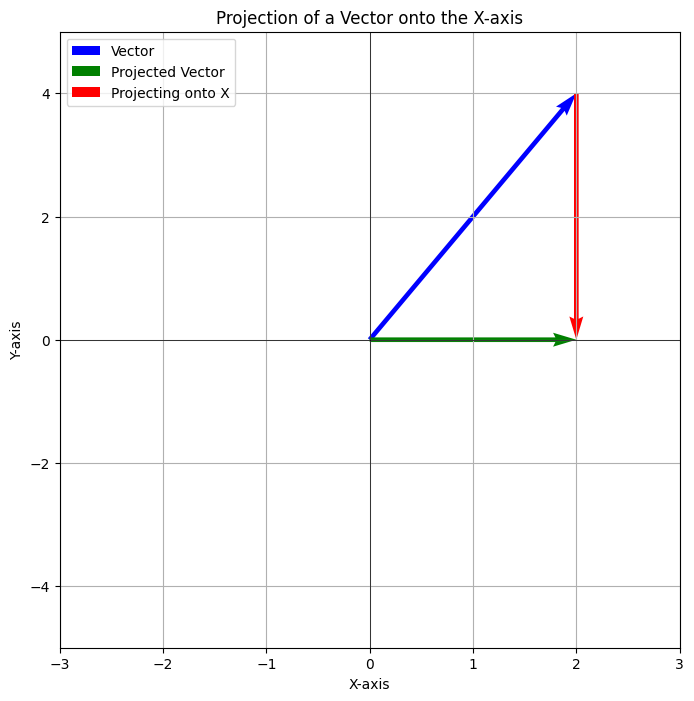

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Define the 2D vector
vector = np.array([2, 4])

# Define the x-axis unit vector
x_axis = np.array([2, 0])

# Calculate the dot product (projection onto x-axis)
projection_length = np.dot(vector, x_axis)
projection = projection_length * x_axis


# Plot the vector and its projection
plt.figure(figsize=(8, 8))
plt.quiver(0, 0, vector[0], vector[1], angles='xy', scale_units='xy', scale=1, color='b', label='Vector')
plt.quiver(0, 0, x_axis[0], x_axis[1], angles='xy', scale_units='xy', scale=1, color='g', label='Projected Vector')

# Plot the projection
plt.quiver(2, 4, 0, -4, angles='xy', scale_units='xy', scale=1, color='r', label='Projecting onto X')
# Plot the x-axis
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)

# Set the limits and labels
plt.xlim(-3, 3)
plt.ylim(-5, 5)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Projection of a Vector onto the X-axis')
plt.legend()
plt.grid(True)
plt.show()


Here we see that when the vector in blue is projected onto the x-axis we see that the magnitude of the projection corresponds to its x-cordinate. Another way of stating this is that the vector **interferes** with the x-axis. Now instead of projecting the vector in blue, let's say that we attempt to project the y-axis onto the x-axis. 

Let's assume we have unit vectors along both axis y = [0, 1] and x = [1, 0]
The dot product is 0.1 + 1.0 = 0. i.e both x and y **do not interfere** with each other. Also note that x and y are orthogonal to each other. So two orthogonal vectors can not interfere with each other.

Let's tie these ideas in with superposition now. If we had the same number of features as hidden dimensions, one of the ways a neural network can learn to represent each of these features with a perfect 1-to-1 mapping is by ensuring that all the neurons i.e. all the rows of the weight matrix are orthogonal to each other. **Since the features are represented orthognally there's no interference between them.**

However, realistically speaking its impossible for there to be the same number of hidden dimensions as features. Superposition allows for a neuron to represent multiple features, since representing all the features orthogonally is impossible superposition states that features tend to be nearly orthogonal. In fact according to the Johnson–Lindenstrauss [lemma](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma) the number of vectors that can be nearly orthogonal to each other grows exponentially with the number of dimensions.


To help with visualizing this, let's say that we have 2 features (A, B) and want to represent them in a 2-d space. Since there are 2-dims, A and B can be orthogonal to each other, for simplicity let's just say that A is represented along the x-axis and B along the y-axis.

Now, if we add another feature C it'd be impossible to make all three orthogonal to each other because we're in a 2-d space. So, instead we have to learn these features such that they minimally interfere with each other. How A, B and C are represented directionally depends on a lot of factors like the importance of each feature and their sparsity. Let's say that the importance A far outweights that of B and C, in that case A should be **interfered with as less as possible**. 

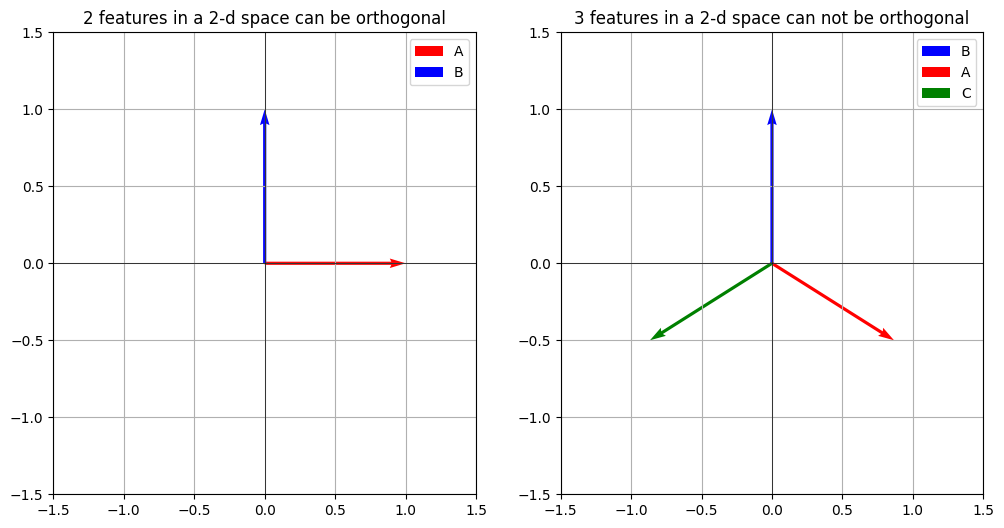

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define the vectors
A = np.array([1, 0])
B = np.array([0, 1])
C = np.array([1, 1])
C = C / np.linalg.norm(C)  # Normalize C to make it a unit vector

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot: A and B along the x and y axis
axs[0].quiver(0, 0, A[0], A[1], angles='xy', scale_units='xy', scale=1, color='r', label='A')
axs[0].quiver(0, 0, B[0], B[1], angles='xy', scale_units='xy', scale=1, color='b', label='B')
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_ylim(-1.5, 1.5)
axs[0].axhline(0, color='k', linewidth=0.5)
axs[0].axvline(0, color='k', linewidth=0.5)
axs[0].grid(True)
axs[0].legend()
axs[0].set_title('2 features in a 2-d space can be orthogonal')

# Second subplot: B along the Y-axis, A is 120 degrees to B and C is 120 degrees to A
axs[1].quiver(0, 0, B[0], B[1], angles='xy', scale_units='xy', scale=1, color='b', label='B')
# rotate B by 120 degrees
B_120 = np.array([B[0] * np.cos(np.pi / 3) - B[1] * np.sin(np.pi / 3), B[0] * np.sin(np.pi / 3) + B[1] * np.cos(np.pi / 3)])
# rotate B by 240 degrees
B_240 = np.array([B[0] * np.cos(2 * np.pi / 3) - B[1] * np.sin(2 * np.pi / 3), B[0] * np.sin(2 * np.pi / 3) + B[1] * np.cos(2 * np.pi / 3)])
axs[1].quiver(0, 0, -B_120[0], -B_120[1], angles='xy', scale_units='xy', scale=1, color='r', label='A')
axs[1].quiver(0, 0, B_240[0], B_240[1], angles='xy', scale_units='xy', scale=1, color='g', label='C')

axs[1].set_xlim(-1.5, 1.5)
axs[1].set_ylim(-1.5, 1.5)
axs[1].axhline(0, color='k', linewidth=0.5)
axs[1].axvline(0, color='k', linewidth=0.5)
axs[1].grid(True)
axs[1].legend()
axs[1].set_title('3 features in a 2-d space can not be orthogonal')

plt.show()

### Superposition and Sparsity

Sparsity of features encourages superposition! Let's say that A, B and C are naturally sparse i.e. these features have non-zero values very rarely. In such a scenario interference becomes minimal. For e.g. if each feature has a probability of being non-zero of 0.05 (sparsity factor). The probability of all features being non-zero is 1.25e-4!

Sparsity of features is infact a very natural phenomenon. Think of the millions (if not billions) of things that an LLM knows about. For any given query only a handful of the concepts that an LLM knows are going to be relevant to answer the query. In the next section we'll get to see how sparsity coupled with a non-linearity i.e. an activation function encourages superposition.

## Exhibiting Superposition in a Toy Model

In this section we will show how a toy model starts exhibiting superposition as our featuers start becoming sparse. In fact, the greater the sparsity the more features the model learns to represent. 

### Model

We'll follow Anthropic's original blog and use a simple architecture. The model will be a very basic auto-encoder, since this entire blog has been about how a model learns to represent features, an auto-encoder is a perfect example of a model that tries to do exactly that. Our inputs will be  N-dimensional tensors and encode it into a space of shape H-dims where (N > H). We'll then apply the transpose of W to recover the original feature X. 

In order to highlight the role of a non-linearity in superposition we'll compare the behavior of a linear model vs a non-linear model. We'll use relu as our non-linear function.

Since we're training an auto-encoder our objective will be the MSE loss where we minimize the difference between the original features and the features recovered by our model. Note that we also introduce a trainable **bias** parameter, the importance of the bias term will become more apparent as we progress through this article.

To sum up we have two models

#### Model 1
$$
Encoding: Z = W @ X
$$

$$
Decoding: \hat{X} = W^T @ Z + B
$$

#### Model 2
$$
Encoding: Z = W @ X
$$

$$
Decoding: \hat{X} = relu(W^T @ Z + B)
$$

##### Loss Function
Let's assume that the Importance of each feature is represented as a vector **I** of shape (N, )
$$
Objective: Minimize ( \text{MSE}(I * X, I * \hat{X}) )
$$
All the code shown is also available as a notebook (here)[]. 

## Code
First, let's get import all the packages we need.

In [31]:
!pip install -qqq torch

from torch import nn
import torch
import numpy as np
import torch.optim as optim

torch.manual_seed(42)

Let's create our model now

In [32]:
class DummyModel(nn.Module):
    def __init__(
        self, 
        feature_imp: torch.Tensor, 
        num_features: int = 5, 
        hidden_dim: int = 2, 
        use_relu: bool = False
    ):
        """
        A dummy autoencoder model.
        Args:
            feature_imp (torch.Tensor): A tensor of shape (num_features,) representing the 
                importance of each feature.
            num_features (int, optional): The number of features our input data has. Defaults to 5.
            hidden_dim (int, optional): The hidden size has to be less than `num_features`. Defaults to 2.
            use_relu (bool, optional): Whether to use relu as the non-linearity. Defaults to False.
        """
        assert hidden_dim < num_features, 'Hidden size has to be less than the number of features'
        super(DummyModel, self).__init__()
        
        self.W = nn.Parameter(torch.empty(num_features, hidden_dim))
        nn.init.xavier_normal_(self.W)
        self.bias = nn.Parameter(torch.zeros(num_features))
        self.use_relu = use_relu
        self.feature_imp = feature_imp
    
    def forward(self, x):
        hidden = torch.matmul(x, self.W)
        reconstructed_x = torch.matmul(hidden, self.W.T) + self.bias
        if self.use_relu:
            reconstructed_x = nn.functional.relu(reconstructed_x)
        return reconstructed_x

Let's do a sanity check against the shape of our outputs, since we are training an auto-encoder the shape of our inputs and outputs need to match.

Also note that we're setting N=5 and H=2. We create a feature importance vector that get smaller as we progress through the indices.

In [33]:
num_features = 5
feature_imps = 0.9 ** torch.arange(num_features)
print(f"Feature importances: {feature_imps}")
test_model = DummyModel(feature_imps, num_features=num_features, hidden_dim=2, use_relu=False)
x = torch.rand(1, num_features)
# Run a single forward pass
output = test_model(x)

# Print inputs and outputs
print("Input:", x)
print("Output:", output)
# Instantiate the model
assert output.shape == x.shape, 'Output shape is incorrect'


Feature importances: tensor([1.0000, 0.9000, 0.8100, 0.7290, 0.6561])
Input: tensor([[0.2696, 0.4414, 0.2969, 0.8317, 0.1053]])
Output: tensor([[ 0.1525,  0.0892, -0.5377,  1.1784,  0.1981]], grad_fn=<AddBackward0>)


Let's now setup the code for training a model. Since we're just trying to show the phenomenon of superposition, we don't concern ourselves with a validation/test set.

In [34]:
def train(
    model, 
    optimizer, 
    scheduler, 
    num_steps, 
    batch_size, 
    num_features, 
    feature_sparsity, 
    log_interval=200
):
    """
    A simple training loop for the dummy model.

    Args:
        model: The model to train
        optimizer: The optimizer to use
        scheduler: The learning rate scheduler
        num_steps: The number of steps to train
        batch_size: The batch size
        num_features: The number of features per input i.e. N
        feature_sparsity: The sparsity of the input features, a probability between 0 and 1
        log_interval (int, optional): How often we want to log the loss. Defaults to 200.
    """
    for step in range(num_steps):
        # Generate random batch of inputs
        inputs = torch.randn(batch_size, num_features)
        
        # create random feature mask
        mask = torch.rand((batch_size, num_features)) > feature_sparsity
        inputs = inputs * mask
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = (model.feature_imp * ((outputs - inputs)**2)).sum(dim=1)
        loss = loss.mean()
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Print loss every log_interval steps
        if step % log_interval == 0:
            print("Learning rate:", scheduler.get_last_lr())
            print(f'Step [{step}/{num_steps}], Loss: {loss.item():.4f}')

We'll train the model using a cosine learning rate schedule for 10000 steps and a batch size of 1024 but with **no sparsity**.

Let's create some helper functions for visualizations.
1. `plot_model_weights`: This function plots each row of our learned Weight matrix as points in our 2-d space. 2-d because our hidden dim is 2.
2. `plot_feature_interactions`: Since each row corresponds to the representation of a feature we can measure the **interference** of one feature with another by computing the dot-product between each row with another row. This function plots a heatmap showing the degree of interference between each feature.
3. `plot_bias`: A heatmap of the learned bias vectors.
4. `plot_interference`: This functions is very similar to `plot_feature_interactions` with the only difference being that we aggregrate the interference of feature i with all features !=i. A feature interacting with itself isn't regarded as interference.

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_weights(model):
    # Plot the learned weights on a 2D grid
    plt.figure(figsize=(6, 6))
    weights = model.W.detach().numpy()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(weights)))
    # Calculate the L2 norm of each weight vector
    l2_norms = np.linalg.norm(weights, axis=1)
    
    # Plot the weights with size based on their L2 norm
    plt.scatter(weights[:, 0], weights[:, 1], s=l2_norms * 100, c=colors, edgecolor='black')
    
    # Plot lines connecting the weights to the origin
    for weight in weights:
        plt.plot([0, weight[0]], [0, weight[1]], 'r--')
    
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title('2D Grid Plot of Learned Parameters')
    plt.xlabel('Parameter 1')
    plt.ylabel('Parameter 2')
    plt.grid(True)
    plt.show()
    
def plot_feature_interactions(model):
    feature_matrix = model.W.detach() @ model.W.detach().T
    plt.imshow(feature_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Feature Interactions Heatmap')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Index')
    plt.show()

def plot_bias(model):
    plt.imshow(model.bias.detach().view(1, -1), cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Bias Parameters')
    plt.xlabel('Feature Index')
    plt.show()
    
def plot_interference(model):
    interference_scores = np.zeros((model.W.shape[0]))
    for i in range(model.W.shape[0]):
        interference = model.W[i].detach().view(1, -1) @ model.W.T.detach()
        interference = interference.squeeze()
        if i == 0:
            interference_scores[i] = interference[1:].sum().item()
        elif i < model.W.shape[0] - 1:
            interference_scores[i] = interference[:i].sum().item() + interference[i+1:].sum().item()
        else:
            interference_scores[i] = interference[:i].sum().item()
    
    plt.imshow(interference_scores.reshape(-1, 1), cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Interference Scores')
    plt.xlabel('Feature Index')
    plt.show()

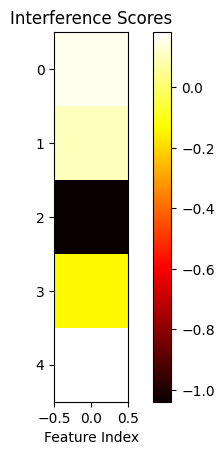

In [36]:
plot_interference(test_model)

Finally let's wrap all of our plotting helper functions into a single function.

In [37]:
def plot_all(model):
    plot_model_weights(model)
    plot_feature_interactions(model)
    plot_bias(model)
    plot_interference(model)

We'll also create a function to print out the angles between each row of the weight matrix. Remember, that orthogonal vectors represent no-interference.

In [38]:
import torch

def plot_angles_between_weights(model):
    num_weights = model.W.shape[0]
    angles = []

    for i in range(num_weights):
        for j in range(i + 1, num_weights):
            cosine_similarity = torch.nn.functional.cosine_similarity(model.W[i], model.W[j], dim=0)
            angle = torch.acos(cosine_similarity).item() * (180.0 / torch.pi)
            angles.append((i, j, angle))
            print(f'Angle between weights {i} and {j}: {angle:.2f} degrees')

In [39]:
plot_angles_between_weights(test_model)

Angle between weights 0 and 1: 23.56 degrees
Angle between weights 0 and 2: 168.49 degrees
Angle between weights 0 and 3: 37.05 degrees
Angle between weights 0 and 4: 9.14 degrees
Angle between weights 1 and 2: 144.93 degrees
Angle between weights 1 and 3: 60.61 degrees
Angle between weights 1 and 4: 14.42 degrees
Angle between weights 2 and 3: 154.46 degrees
Angle between weights 2 and 4: 159.35 degrees
Angle between weights 3 and 4: 46.19 degrees


All right! We're ready to train a few models and witness superposition in action. First let's configure some things training steps etc.

In [40]:
# Training loop
num_steps = 10000
batch_size = 1024
num_features = 5
hidden_dim = 2
learning_rate = 1e-3

## Training a model with no sparsity.
Let's train a model with no sparsity first and visualize the results.

In [41]:
linear_model = DummyModel(feature_imps, num_features=num_features, hidden_dim=hidden_dim, use_relu=False)
# Define loss function and optimizer
optimizer = optim.AdamW(linear_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
feature_sparsity_prob = 0
train(linear_model, optimizer, scheduler, num_steps, batch_size, num_features, feature_sparsity_prob)

Learning rate: [0.0009999999753259891]
Step [0/10000], Loss: 2.9942
Learning rate: [0.0009990034764772327]
Step [200/10000], Loss: 2.5678
Learning rate: [0.0009960376388798247]
Step [400/10000], Loss: 2.4186
Learning rate: [0.0009911141673397982]
Step [600/10000], Loss: 2.3345
Learning rate: [0.000984252492550001]
Step [800/10000], Loss: 2.4338
Learning rate: [0.0009754796944060304]
Step [1000/10000], Loss: 2.3237
Learning rate: [0.0009648303951342477]
Step [1200/10000], Loss: 2.2886
Learning rate: [0.0009523466226536772]
Step [1400/10000], Loss: 2.2496
Learning rate: [0.0009380776447110064]
Step [1600/10000], Loss: 2.1978
Learning rate: [0.0009220797744433006]
Step [1800/10000], Loss: 2.3128
Learning rate: [0.0009044161481357741]
Step [2000/10000], Loss: 2.1877
Learning rate: [0.0008851564760517177]
Step [2200/10000], Loss: 2.2267
Learning rate: [0.000864376767317943]
Step [2400/10000], Loss: 2.1842
Learning rate: [0.0008421590299514746]
Step [2600/10000], Loss: 2.1716
Learning rate: 

In [42]:
print(linear_model.W)

Parameter containing:
tensor([[ 2.6402e-01,  9.6451e-01],
        [ 9.6451e-01, -2.6402e-01],
        [-8.6666e-04, -9.6285e-04],
        [-2.1106e-03,  2.7462e-03],
        [-8.1111e-04,  6.3841e-04]], requires_grad=True)


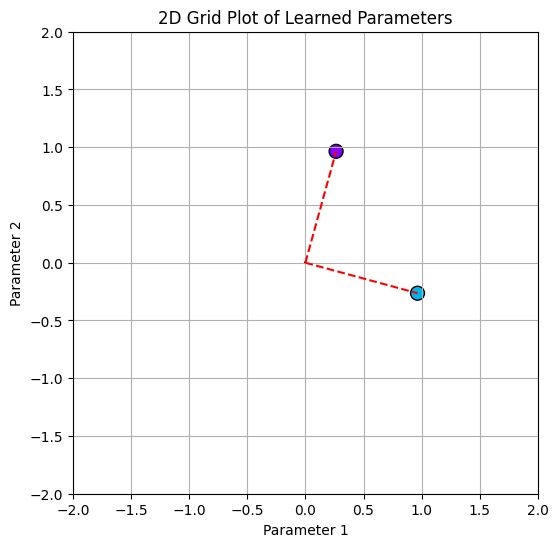

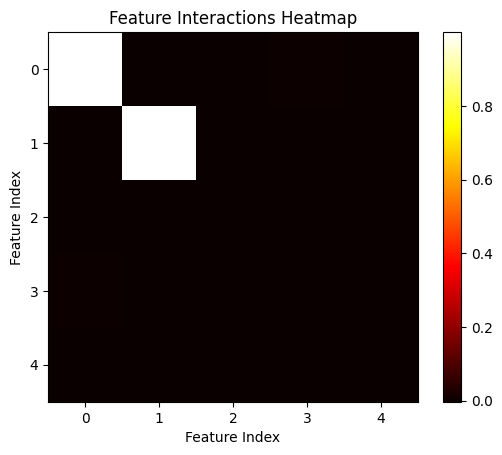

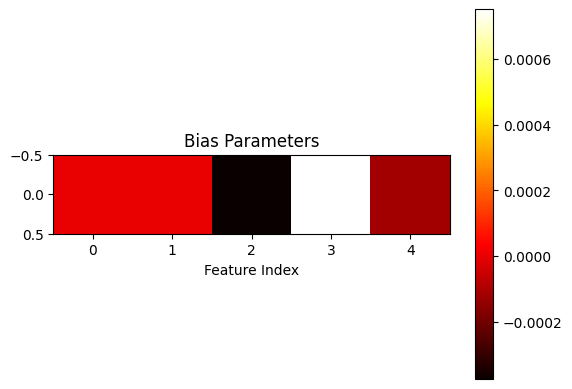

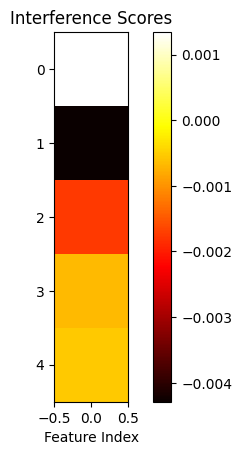

In [43]:
plot_all(linear_model)

### Conclusions to draw
1. From printing out the values of our weights we see that there's a correlation between feature importance and the magnitude of the weights corresponding to a feature. We can also notice that the weight magnitude does take a dive down after the 2nd feature i.e. from the moment the number of features exceeds the number of hidden dimensions. The low weight magnitudes indicate that features after the 2nd one are barely being represented.
2. Our plot of weights shows that the first two weights seem to be **orthogonal** to each other, printing out the angles between the weights confirms the same.
3. Our feature interactions heat-map further reinforces 1 and 2, we see that all feature interactions are almost at 0, besides at the diagonal of feature 1 and 2, where they are interacting with themselves.
4. The bias and interference heat-maps are almost 0 for all values, keep this in mind for the next section.

In fact our results are very simiar to what would happen if we try to run PCA on the same data, where we've learnt the first two principal components. 

**So a simple linear model with no non-linearity seems to be limited by the hidden size in terms of how many features it can learn.** You'll get very similar results even if you train a linear model on sparse features i.e. set `feature_sparsity_prob > 0`. This will be left as an exercise for the reader in case they need to convince themselves.

## Train a linear model with sparsity

In [44]:
linear_model_with_sparsity = DummyModel(feature_imps, num_features=num_features, hidden_dim=hidden_dim, use_relu=False)
feature_sparsity_prob = 0.5
optimizer = optim.AdamW(linear_model_with_sparsity.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
train(linear_model_with_sparsity, optimizer, scheduler, num_steps, batch_size, num_features, feature_sparsity_prob)

Learning rate: [0.0009999999753259891]
Step [0/10000], Loss: 2.5288
Learning rate: [0.0009990034764772327]
Step [200/10000], Loss: 1.3718
Learning rate: [0.0009960376388798247]
Step [400/10000], Loss: 1.1966
Learning rate: [0.0009911141673397982]
Step [600/10000], Loss: 1.1891
Learning rate: [0.000984252492550001]
Step [800/10000], Loss: 1.1808
Learning rate: [0.0009754796944060304]
Step [1000/10000], Loss: 1.2067
Learning rate: [0.0009648303951342477]
Step [1200/10000], Loss: 1.1124
Learning rate: [0.0009523466226536772]
Step [1400/10000], Loss: 1.1383
Learning rate: [0.0009380776447110064]
Step [1600/10000], Loss: 1.1607
Learning rate: [0.0009220797744433006]
Step [1800/10000], Loss: 1.1154
Learning rate: [0.0009044161481357741]
Step [2000/10000], Loss: 1.1281
Learning rate: [0.0008851564760517177]
Step [2200/10000], Loss: 1.1129
Learning rate: [0.000864376767317943]
Step [2400/10000], Loss: 1.1888
Learning rate: [0.0008421590299514746]
Step [2600/10000], Loss: 1.1568
Learning rate: 

In [45]:
print(linear_model_with_sparsity.W)

Parameter containing:
tensor([[-9.0260e-01, -4.3043e-01],
        [ 4.3043e-01, -9.0259e-01],
        [ 1.9249e-05, -6.1033e-03],
        [ 2.7020e-03, -1.5086e-03],
        [ 9.4099e-05,  2.1472e-03]], requires_grad=True)


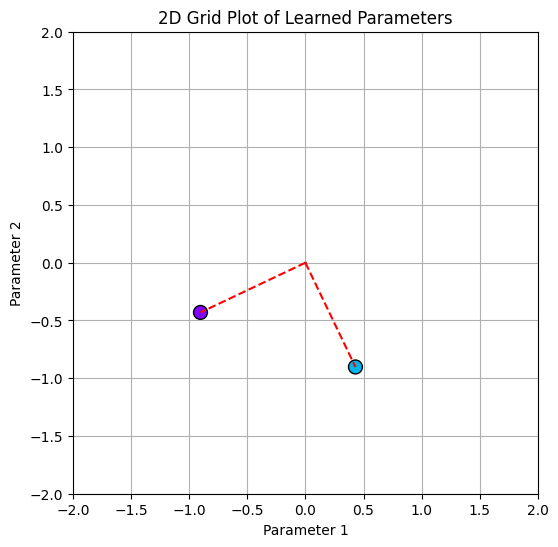

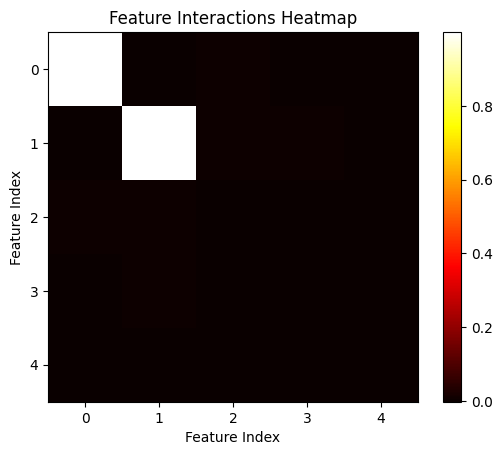

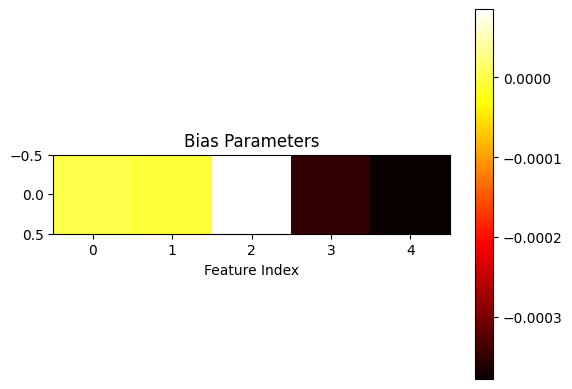

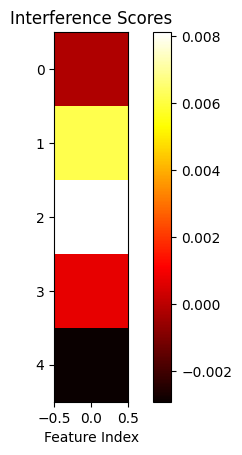

In [46]:
plot_all(linear_model_with_sparsity)

## Train the model with sparsity and non-linearity

Alrighty, now that we've established a baseline with a linear model and proved that it can't learn more features than hidden dims. Let's train a non-linear model and see if superposition makes an appearance.

In [47]:
non_linear_model_with_sparsity = DummyModel(feature_imps, num_features=num_features, hidden_dim=hidden_dim, use_relu=True)
optimizer = optim.AdamW(non_linear_model_with_sparsity.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
feature_sparsity_prob = 0.5
train(non_linear_model_with_sparsity, optimizer, scheduler, num_steps, batch_size, num_features, feature_sparsity_prob)

Learning rate: [0.0009999999753259891]
Step [0/10000], Loss: 2.2425
Learning rate: [0.0009990034764772327]
Step [200/10000], Loss: 1.7707
Learning rate: [0.0009960376388798247]
Step [400/10000], Loss: 1.7889
Learning rate: [0.0009911141673397982]
Step [600/10000], Loss: 1.6538
Learning rate: [0.000984252492550001]
Step [800/10000], Loss: 1.7010
Learning rate: [0.0009754796944060304]
Step [1000/10000], Loss: 1.5926
Learning rate: [0.0009648303951342477]
Step [1200/10000], Loss: 1.5745
Learning rate: [0.0009523466226536772]
Step [1400/10000], Loss: 1.6094
Learning rate: [0.0009380776447110064]
Step [1600/10000], Loss: 1.6836
Learning rate: [0.0009220797744433006]
Step [1800/10000], Loss: 1.5872
Learning rate: [0.0009044161481357741]
Step [2000/10000], Loss: 1.5239
Learning rate: [0.0008851564760517177]
Step [2200/10000], Loss: 1.4907
Learning rate: [0.000864376767317943]
Step [2400/10000], Loss: 1.6371
Learning rate: [0.0008421590299514746]
Step [2600/10000], Loss: 1.5637
Learning rate: 

In [48]:
print(non_linear_model_with_sparsity.W)

Parameter containing:
tensor([[-0.6713, -0.7695],
        [ 0.7633, -0.6665],
        [ 0.1703, -0.1484],
        [-0.1165, -0.1336],
        [ 0.0969, -0.0838]], requires_grad=True)


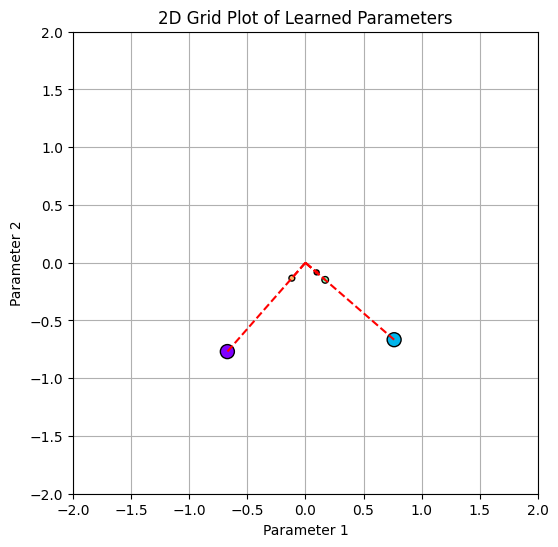

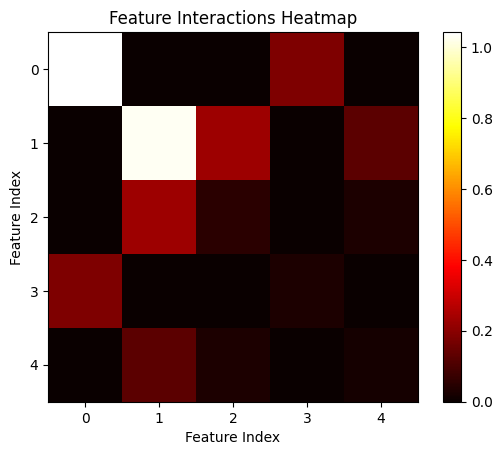

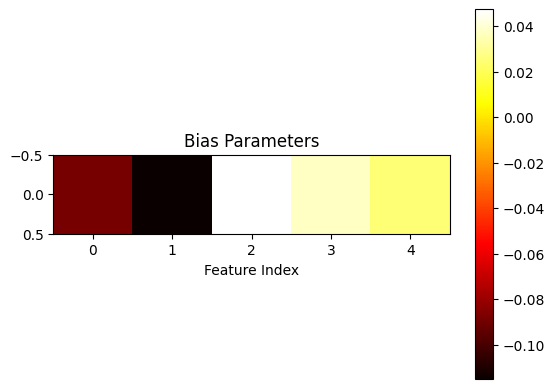

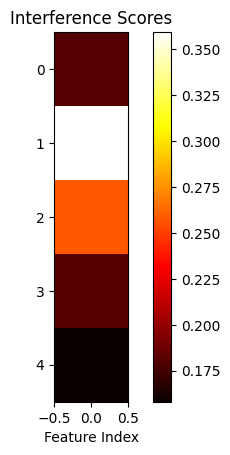

In [49]:
plot_all(non_linear_model_with_sparsity)

### Hello Superposition!

Just printing our weights out shows that all features are represented by weights of magnitude on almost the same degree of order. Meaning that our model is learning to represent all features! Similar to the linear model the order of the norms of the weights follows the feature importances.

Our plot of weights re-iterates point 1, the important thing to note here is that despite having 5 features we still seem to have just 2 directions. We have two features being represented on the diagonal going from bottom-left to top-right and we have three features in the orthogonal direction.

#### Understanding the role of the bias vector
The bias vector helps the model suss out interference. Let's demonstrate how. From our feature interactions map we see that feature 0 (purple) and 3 (orange) interfere with each other, along with the fact that they are represented along the same dimension.

Let's take a look at how $\hat{X}$ is predicted for feature 0. We'll ignore Relu for the time being and get to it in the next section.

$$
\hat{X}_1 = \sum_i \left( H_0 \cdot W_i^T \right)
$$


Since $H_0$ is represented orthogonally to $W^T_1$, $W^T_2$ and $W^T_4$ the prediction is only affected adversely by the dot product between $H_0$ and $W^T_3$, i.e. the source of interference. 

$$
\hat{X}_1 = \left( H_0 \cdot W_0^T \right) + \left( H_0 \cdot W_3^T \right)
$$

**Adding a negative bias term helps with the model learning to offset any possible positive interference!**

$$
\hat{X}_1 = \left( H_0 \cdot W_0^T \right) + \left( H_0 \cdot W_3^T \right) - B_0
$$


In [50]:
plot_angles_between_weights(non_linear_model_with_sparsity)

Angle between weights 0 and 1: 89.98 degrees
Angle between weights 0 and 2: 90.04 degrees
Angle between weights 0 and 3: 0.03 degrees
Angle between weights 0 and 4: 90.23 degrees
Angle between weights 1 and 2: 0.07 degrees
Angle between weights 1 and 3: 89.94 degrees
Angle between weights 1 and 4: 0.26 degrees
Angle between weights 2 and 3: 90.01 degrees
Angle between weights 2 and 4: 0.19 degrees
Angle between weights 3 and 4: 90.20 degrees


## Train the model with high sparsity and non-linearity

In [51]:
non_linear_model_with_high_sparsity = DummyModel(feature_imps, num_features=num_features, hidden_dim=hidden_dim, use_relu=True)
optimizer = optim.AdamW(non_linear_model_with_high_sparsity.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
feature_sparsity_prob = 0.9
train(non_linear_model_with_high_sparsity, optimizer, scheduler, num_steps, batch_size, num_features, feature_sparsity_prob)

Learning rate: [0.0009999999753259891]
Step [0/10000], Loss: 0.3614
Learning rate: [0.0009990034764772327]
Step [200/10000], Loss: 0.3262
Learning rate: [0.0009960376388798247]
Step [400/10000], Loss: 0.2968
Learning rate: [0.0009911141673397982]
Step [600/10000], Loss: 0.3498
Learning rate: [0.000984252492550001]
Step [800/10000], Loss: 0.2906
Learning rate: [0.0009754796944060304]
Step [1000/10000], Loss: 0.2949
Learning rate: [0.0009648303951342477]
Step [1200/10000], Loss: 0.3364
Learning rate: [0.0009523466226536772]
Step [1400/10000], Loss: 0.2846
Learning rate: [0.0009380776447110064]
Step [1600/10000], Loss: 0.3284
Learning rate: [0.0009220797744433006]
Step [1800/10000], Loss: 0.3203
Learning rate: [0.0009044161481357741]
Step [2000/10000], Loss: 0.2961
Learning rate: [0.0008851564760517177]
Step [2200/10000], Loss: 0.2852
Learning rate: [0.000864376767317943]
Step [2400/10000], Loss: 0.3498
Learning rate: [0.0008421590299514746]
Step [2600/10000], Loss: 0.3359
Learning rate: 

In [52]:
print(non_linear_model_with_high_sparsity.W)

Parameter containing:
tensor([[ 1.0513, -0.1186],
        [-0.5710, -0.8611],
        [-0.3933,  0.9017],
        [ 0.1577,  0.0778],
        [-0.1415,  0.1073]], requires_grad=True)


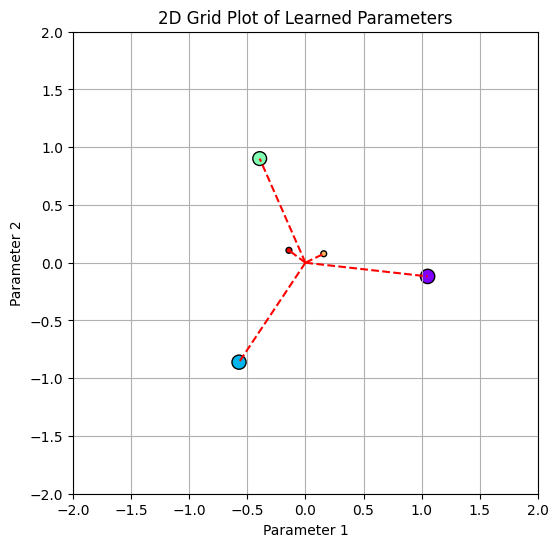

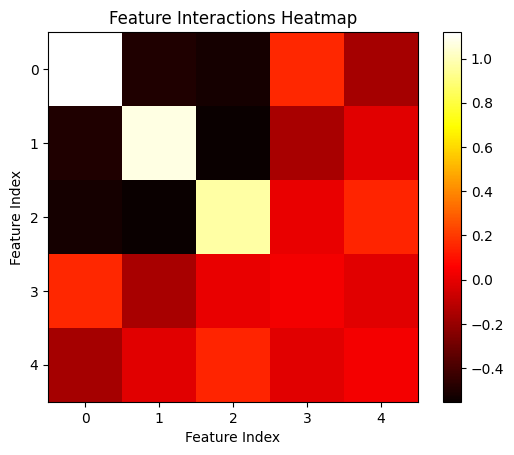

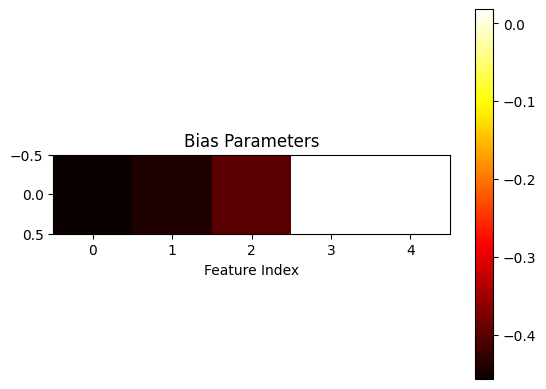

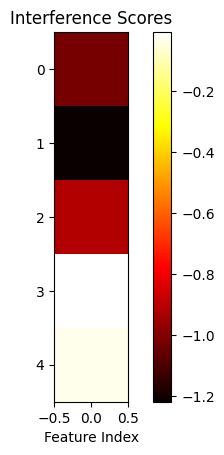

In [53]:
plot_all(non_linear_model_with_high_sparsity)

In [54]:
plot_angles_between_weights(non_linear_model_with_high_sparsity)

Angle between weights 0 and 1: 117.11 degrees
Angle between weights 0 and 2: 120.00 degrees
Angle between weights 0 and 3: 32.68 degrees
Angle between weights 0 and 4: 149.28 degrees
Angle between weights 1 and 2: 122.88 degrees
Angle between weights 1 and 3: 149.80 degrees
Angle between weights 1 and 4: 93.61 degrees
Angle between weights 2 and 3: 87.32 degrees
Angle between weights 2 and 4: 29.28 degrees
Angle between weights 3 and 4: 116.60 degrees


#### Understanding the role of ReLU

As we increase the sparsity we observe more unique directions showing up. In our case we see that with a sparsity factor of 0.8 we see that all features are represented in unique directions. We also see that our features are getting **less orthogonal**.

Let's demonstrate how the ReLU operation in particular helps suss out interference despite the features not being orthogonal to each other.

Let's focus on feature 2 (green) in particular. We see that it has a notable **negative interference** with both feature 0 and feature 1. As before let's roll out the equation for how $\hat{X_2}$ is predicted. We'll ignore the small _positive interference_ with features 3 and 4 since the negative bias term helps with sussing them out.

$$
\hat{X}_2 = \text{Relu}(\left( H_2 \cdot W_0^T \right) + (\left( H_2 \cdot W_1^T \right)) + (\left( H_2 \cdot W_2^T \right)) - B_2) 
$$

You can probably see where we're going here, since the Relu operation zeros out all negative values, all negative interferences are ignored while recovering the original feature! Sparsity plays a huge role here, since all of our features have a high sparsity, it isn't that often that there is any interference in the first place because $X_0$, $X_1$ are going to be 0 nearly 80% of the time. Since the features are sparse $H_2$ isn't affected by them and the subsequent generation of $\hat{X_2}$ isn't either.

So the greater the sparsity, the less often Relu actually plays a role in dealing with interference. It's for this reason that as sparsity increases we see more features being represented. Using a simple non linearity that only acts on the rare occasion cuts down the cost of learning to represent a sparse feature!

## Conclusion
In this article, we explored Superposition one of the key ideas in Mechanistic Interpretability that states that when features are sparse models can learn to represent features in the form of directions in a vector space and we can in fact learn to represent more features than there are hidden dimensions.

We learned about how representing features orthogonally ensures no interference in recovering features and the role of the bias and non-linearity in supporting superposition. We created a toy-model and showed how even the simplest of auto-encoders can exhibit superposition.

However, we've just scratched the surface of Mech Interp, and we're still far away from answering how does all of this tie up with LLMs. We hope to go deeper and eventually get to answering some of those questions in the future, in any case we hope that this article has broken down the idea of Superposition in a reader friendly manner that piqued your interest.

_Until the next time take care and be kind_.